# Model Predictive Control (6) - Checkpoint 5 - The crane example

In [1]:
from IPython.display import Image, IFrame
import ipywidgets as wg
import numpy as np
import matplotlib.pyplot as plt
import time
from casadi import MX, vertcat, Function, nlpsol, diag
import matplotlib.pyplot as plt

!pip install casadi

files_root = "https://www.mazenalamir.fr/files/MPC/"

width=800

## The working example (remainder)<a class="anchor" id="Remainder"></a>

In the notebook 2, we worked out a simulator for the example of the crane (see below) using the following set of parameter value:

$$
m=200\ \text{kg}, M=1500\ \text{kg},\ \ell=10\ \text{m}\ \text{and $g=9.81$ m/$s^2$}
$$


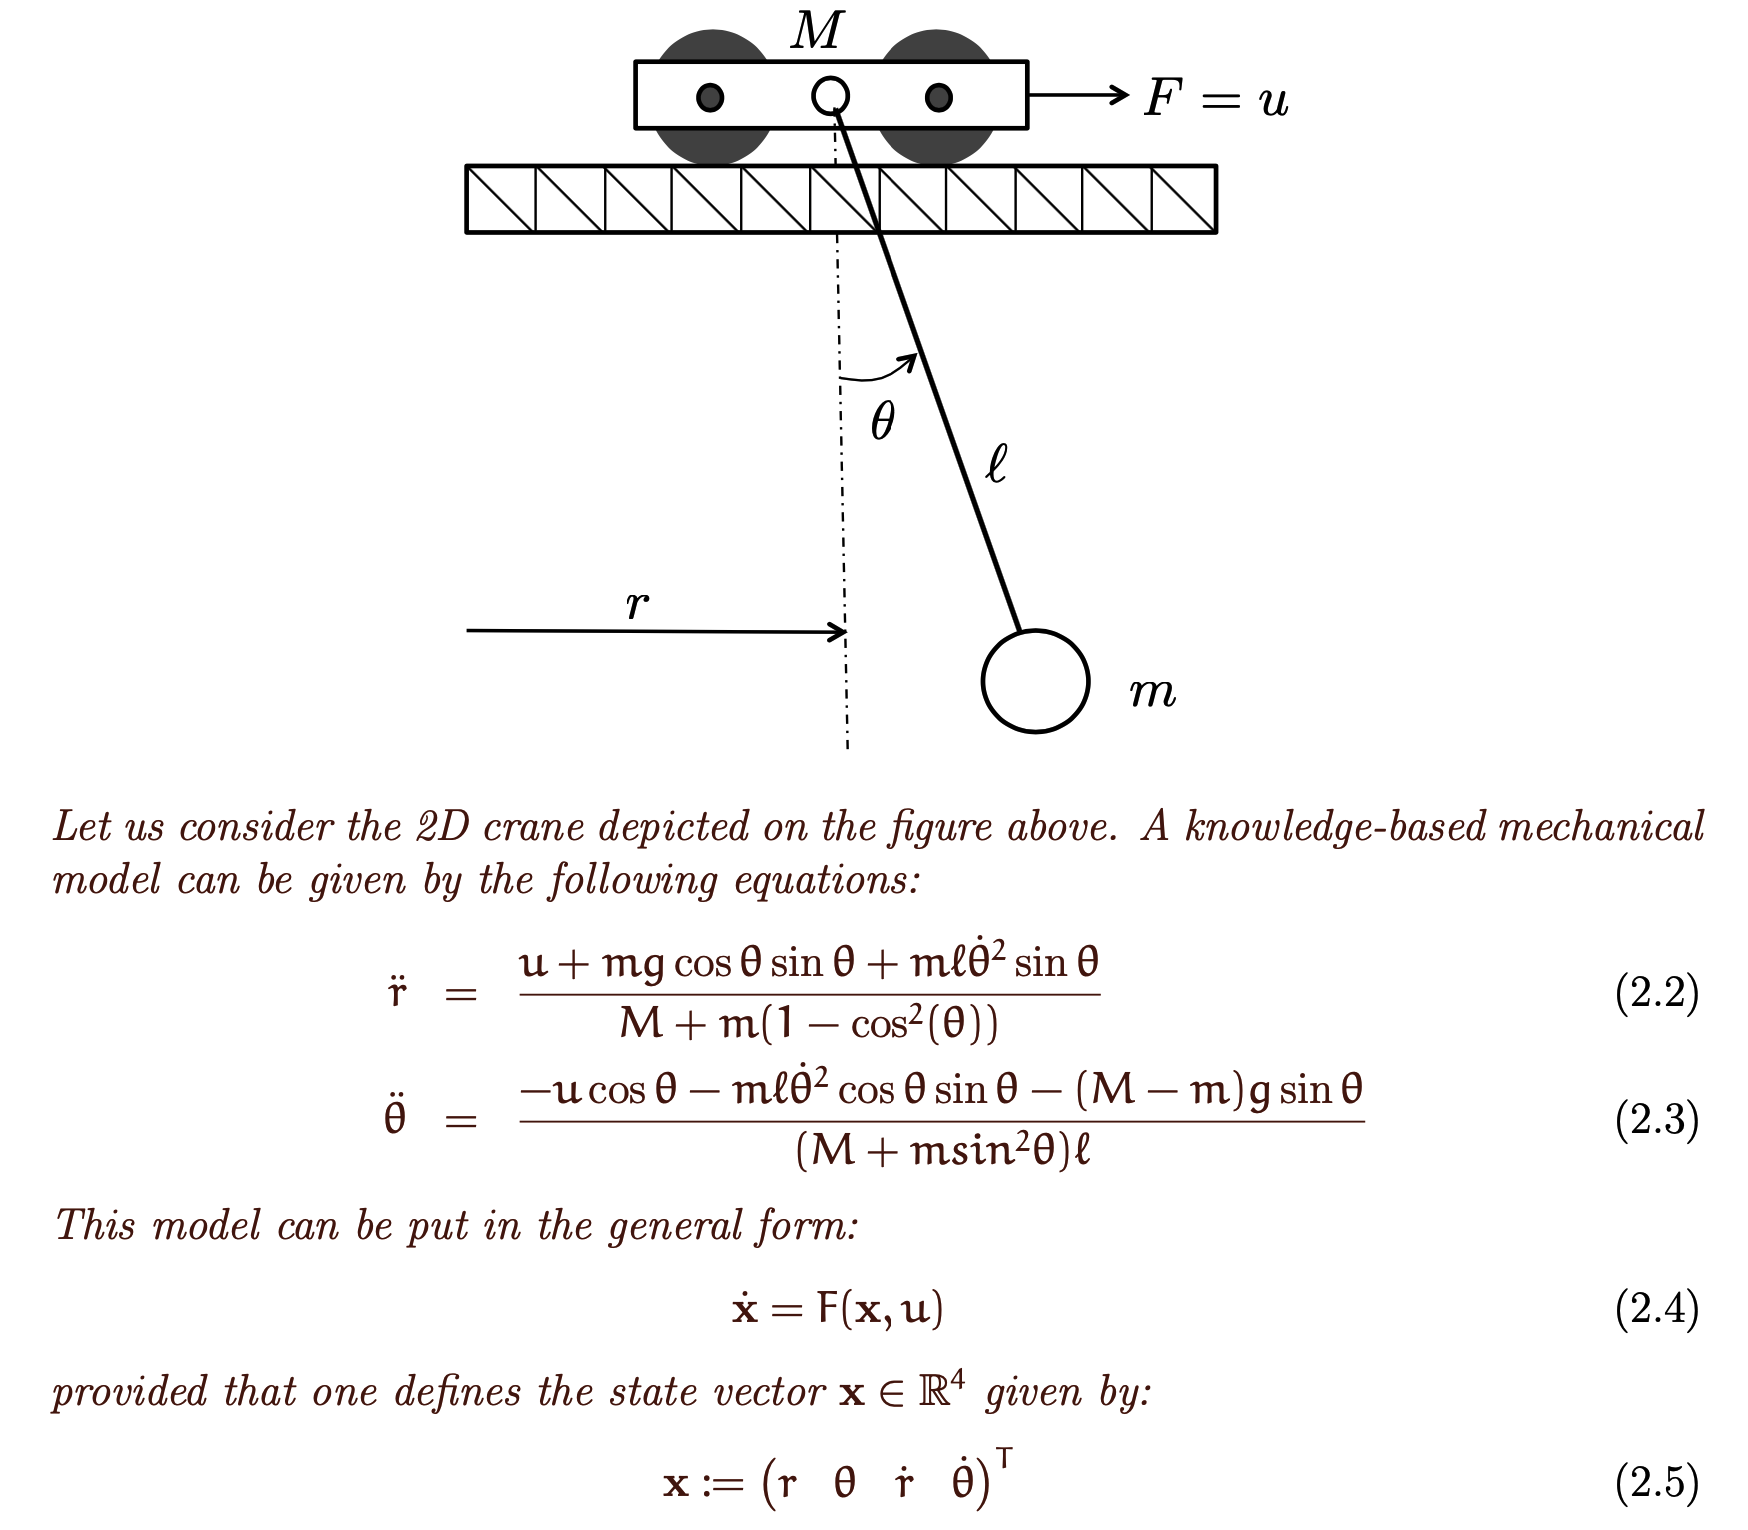

In [4]:
crane = files_root+"crane_equations.png"
display(Image(crane, width=width))

The following constraint has to be satisfied during the operations:

$$\vert \theta\vert < \theta_{max}=0.05$$

### The dynamics<a class="anchor" id="Dynamics"></a>

Definition of the ordinary differential equation describing the system to be controlled. Note that using different values of the paramter vector $p$ in the controller and in the simulated system enables to chech the robustness of the resulting MPC-based closed-loop to modeling errors. 

In [5]:
nx = 4 #number of state 
nu = 1 #number of actuators

# p = (M,m,ell)
p = MX.sym('par', 3) 
gravity = 9.81

# x = (r,theta,drdt, dthetadt)
x = MX.sym('x', nx)
u = MX.sym('u', nu)

cth = np.cos(x[1])
sth = np.sin(x[1])

xdot = vertcat(x[2], 
               x[3], 
               (u[0]+p[1] * gravity * cth*sth
                +p[1] * p[2] * (x[3]**2) *sth)/(p[0]+[1]*(1-cth**2)),
                (-u[0]*cth-p[1]*p[2]*(x[3]**2)*cth*sth-(p[0]-p[1])*gravity*sth)/
                (p[0]+p[1] * (sth**2)*p[2])
              )

# Definition of a map called f taking three argument (x,u,epsilon) and 
# delivering the corresponding state derivative.
# Note that in case many parameter p1, p2, ..., pn are needed, the vertcat command can be used to regroup them 
# in a single parameter vector p=vertcat(p1,p2,...,pn) and the argument list become [x,u,p]

f = Function('f', [x,u, p], [xdot])

### The one-step function <a class="anchor" id="OneStep"></a>

Definition of the ordinary differential equation describing the system to be controlled. 

In [6]:
# The prediction horizon in time unit 

T = 3

#number of control intervals (-> control sampling interval = T/N)

N = 10

#number of Runge-Kutta steps per control sampling interval 
# -> The integration sampling time = T/N/M
# M should be sufficiently high to induce sufficiently small sampling integration step
# This is problem-dependent and should be tested off-line 

M = 1
dt = T/N/M

# The initial state 
x0 = MX.sym('x0', nx)
u = MX.sym('u', nu)
p = MX.sym('par', 3) 
x = x0
for i in range(M):
    k1 = f(x,u, p)
    k2 = f(x+0.5*dt*k1, u, p)
    k3 = f(x+0.5*dt*k2, u, p)
    k4 = f(x+dt*k3, u, p)
    x = x + dt/6*(k1+2*(k2+k3)+k4)
    
F = Function('F', [x0,u,p], [x])   

### Formulating the optimal control problem <a class="anchor" id="FormulatingNLP"></a>

Definition of the optimal control problem and the associated solver.

In [7]:
# Definition of the weighting matrices to be used in the definition of the cost function 

qvec = [100, 10, 1, 1]
rvec = [1e-6]
qf = 1e5

# Declaration of the initial state and the desired pair

x0 = MX.sym('x0', nx)
xd = MX.sym('xd', nx)
ud = MX.sym('ud', nu)
p = MX.sym('p', 3)

# Define the saturation constraints on the control 
umin = [-4e3]
umax = [+4e3]

# Define the bound on the derivative of theta

theta_max = 0.05

# Declaration of the sequence of control over the prediction horizon 
# the control applied on [k,k+1] will be U[k*nu:(k+1)*nu]

U = MX.sym('U', N * nu)
Umin = np.array([umin] * N).flatten()
Umax = np.array([umax] * N).flatten()

# the cost function and state initialization
J = 0 
xk = x0
# Prepare the state trajectory
X = x0
# The list of constraints and its lower and upper bound

g, lbg, ubg = [], [], []

In [8]:
# simulate SYMBOLICALLY over the prediction horizon
for k in range(N-1):
    
    uk = U[k*nu: (k+1)*nu]
    xk = F(xk, uk, p)
    X = vertcat(X, xk)
    ex = xk-xd
    eu = uk-ud
    
    # add ex.T (Q * ex) to J 
    for j in range(nx):
        J += qvec[j] * ex[j] * ex[j]
    
    # add eu.T (R * eu) to J 
    for j in range(nu):
        J += rvec[j] * eu[j] * eu[j]
        
    # add the constraint on the derivative of theta 
    
    g += [xk[1]]
    lbg += [-theta_max]
    ubg += [+theta_max]

    
# add the terminal penalty on the state 
uk = U[(N-1)*nu:]
xk = F(xk, uk, p)
X  = vertcat(X, xk)
ex = xk-xd
eu = uk-ud

# add ex.T (Qf * ex) to J 
for j in range(nx):
    
    J += qf * qvec[j] * ex[j] * ex[j]
    
# This is a by-product function that will enable the simulation of the resulting solution

simu = Function('simu', [x0, U, p], [X])

In [16]:
# Declaring the Single-Shooting problem 

prob_SS = {'f':J, 'x':U, 'g':vertcat(*g), 'p':vertcat(x0, xd, ud, p)}

# declaring the solver 

solver_SS = nlpsol('solver', 'ipopt', prob_SS, {'ipopt':{'max_iter':2000}})

## Definition of the function "MPC feedback" !

In [17]:
def MPC(x, xd, ud, p, U0):
    
    # Solve the problem 
    
    sol = solver_SS(x0=U0, 
                    lbx=Umin, 
                    ubx=Umax, 
                    lbg=lbg, 
                    ubg=ubg, 
                    p=vertcat(x,xd,ud,p))
    
    # Get the optimal control sequence 
    U_opt = sol['x']
    
    # This map return the optimal sequence of control actions 
    # from which only the first action U_opt[0:nu] is to be used 
    # during the current sampling period.
    
    return U_opt
    

## Check a single call of the MPC feedback function

In [11]:
# Let us check this function 

U0 = np.array([[0] for _ in range(N)]).flatten()
x0_ = np.zeros(nx)
xd_ = np.array([1, 0, 0, 0])
ud_ = np.array([0])
p_ = np.array([1500, 200, 10])

t0 = time.time()
U_opt_ol = MPC(x0_, xd_, ud_, p_, U0)
tf = time.time()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       45
Number of nonzeros in Lagrangian Hessian.............:       55

Total number of variables............................:       10
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equa

In [12]:
print(f'The optimal sequence is\n {U_opt_ol}')
print(f'cpu time = {tf-t0}')

The optimal sequence is
 [1781.48, -2277.89, 3497.09, -2187.31, 3408.62, -3415.11, 3634.46, -3750.79, 3343.91, -2979.5]
cpu time = 0.1123199462890625


## Checkpoint 5:

Simulate the resulting closed-loop system where the MPC is based on the nominal values of the parameter 

$$p_{\text{controller}} = [1500, 200, 10]$$

while the simulated controlled system uses a *different real value of the parameter*:

$$p_{\text{real}} = \alpha \times p_{\text{controller}}$$

produce the results for $\alpha \in \{1, 1.1, 1.2, 0.8, 0.9\}$

Comment on the results!

In [1]:
#%load_ext watermark
#print("----")
#%watermark -v -m -p IPython,ipywidgets,casadi,scipy,matplotlib
#print("----")
#%watermark -u -n -t -z